In [ ]:
# Install necessary libraries
!pip install -q datasets transformers
!pip install -U accelerate
!pip install -U transformers
!pip install evaluate
!pip install onnx-tf



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import evaluate
from datasets import load_dataset

In [ ]:
import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Import pretrained model and set training parameters

Edit - learning rate updated after Optuna trial (see last code snippet)

In [ ]:

# Setup: Specify model checkpoint, batch size, epochs, and learning rate.
model_checkpoint = "google/mobilenet_v2_1.0_224"  # Pre-trained MobileNetV2 checkpoint
batch_size = 32
num_epochs = 10
learning_rate = 1e-03 #0.000251

In [ ]:
# Try mounting to a subdirectory within /content/drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Load Dataset

In [ ]:
ds = load_dataset("Muzmmillcoste/dermnet")
metric = evaluate.load("accuracy")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/418M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/418M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/418M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/219M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/13223 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2334 [00:00<?, ? examples/s]

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 13223
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2334
    })
})

In [ ]:
ds["train"].features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections'], id=None)}

In [ ]:
# Explore the dataset
print(ds)
print(ds["train"].features)

example = ds["train"][10]
print(example)
print("Image:", example['image'])
print("Label:", example['label'])

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 13223
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2334
    })
})
{'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'S

# Map label names

In [ ]:
# Create label mappings.
# Create label mappings.
labels = ds["train"].features["label"].names
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for i, label in enumerate(labels)}
print("Example mapping:", id2label[2])

Example mapping: Atopic Dermatitis Photos


# Import Hugging Face Image processing pipeline

In [ ]:
# %%
from transformers import AutoImageProcessor
# Load the image processor from the model checkpoint.
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)
print(image_processor)

preprocessor_config.json:   0%|          | 0.00/406 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


MobileNetV2ImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "MobileNetV2ImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 256
  }
}



# Define torchvision transforms based on the image processor

In [ ]:

from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)


In [ ]:


normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
else:  # use shortest_edge if available
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)


train_transforms = Compose([
    RandomResizedCrop(crop_size),
    RandomHorizontalFlip(),
    ToTensor(),
    normalize,
])

# Validation transforms.
val_transforms = Compose([
    Resize(size),
    CenterCrop(crop_size),
    ToTensor(),
    normalize,
])

# Preprocessing functions to apply transforms to each batch.
def preprocess_train(example_batch):
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    example_batch["pixel_values"] = [
        val_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch


# Test Train Split + Load

In [ ]:

# Split the training set into training and validation (75/25 split).
splits = ds["train"].train_test_split(test_size=0.25, seed=42)
train_ds = splits['train']
val_ds = splits['test']

# Apply preprocessing transforms.
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)


In [ ]:
# Define a collate function for DataLoader.
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
# Create DataLoaders.
# Create DataLoaders with updated batch size
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                          collate_fn=collate_fn, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)



# Load the Model

In [ ]:
from transformers import AutoModelForImageClassification
# Load the pre-trained classification model.
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
)
model = model.to("cuda" if torch.cuda.is_available() else "cpu")
print(model)

config.json:   0%|          | 0.00/69.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

Some weights of MobileNetV2ForImageClassification were not initialized from the model checkpoint at google/mobilenet_v2_1.0_224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1001]) in the checkpoint and torch.Size([23]) in the model instantiated
- classifier.weight: found shape torch.Size([1001, 1280]) in the checkpoint and torch.Size([23, 1280]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MobileNetV2ForImageClassification(
  (mobilenet_v2): MobileNetV2Model(
    (conv_stem): MobileNetV2Stem(
      (first_conv): MobileNetV2ConvLayer(
        (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (normalization): BatchNorm2d(32, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
        (activation): ReLU6()
      )
      (conv_3x3): MobileNetV2ConvLayer(
        (convolution): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
        (normalization): BatchNorm2d(32, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
        (activation): ReLU6()
      )
      (reduce_1x1): MobileNetV2ConvLayer(
        (convolution): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (normalization): BatchNorm2d(16, eps=0.001, momentum=0.997, affine=True, track_running_stats=True)
      )
    )
    (layer): ModuleList(
      (0): MobileNetV2InvertedResidual(
        (expand_1x1): MobileNe

In [ ]:
# Define loss and optimizer.
# Define loss and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08)



In [ ]:
# Calculate total training steps and set warmup steps (10% of total steps).
total_steps = num_epochs * len(train_loader)
warmup_steps = int(0.13284 * total_steps)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda step: min(1.0, 0.1 + 0.9 * step / warmup_steps))


In [ ]:
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer, lambda step: min(1.0, 0.1 + 0.9 * step / warmup_steps)
)

In [ ]:
gradient_accumulation_steps = 4


# Train

In [ ]:
from tqdm import tqdm
import numpy as np

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.train()

early_stop = False  # Flag for early stopping

for epoch in range(num_epochs):
    running_loss = 0.0
    running_correct = 0
    total_train = 0
    optimizer.zero_grad()

    for i, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False)):
        inputs = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        loss = loss / gradient_accumulation_steps
        loss.backward()

        running_loss += loss.item() * inputs.size(0) * gradient_accumulation_steps

        preds = outputs.argmax(dim=1)
        running_correct += (preds == labels).sum().item()
        total_train += inputs.size(0)

        if (i + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()

    if (i + 1) % gradient_accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()

    train_epoch_loss = running_loss / total_train
    train_epoch_acc = running_correct / total_train
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_acc)
    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_epoch_loss:.4f} - Training Acc: {train_epoch_acc:.4f}")

    # Validation Loop.
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    total_val = 0

    for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False):
        inputs = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        val_running_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1)
        val_correct += (preds == labels).sum().item()
        total_val += inputs.size(0)

    val_epoch_loss = val_running_loss / total_val
    val_epoch_acc = val_correct / total_val
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)
    print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {val_epoch_loss:.4f} - Validation Acc: {val_epoch_acc:.4f}")

    if val_epoch_acc >= 0.96:
        print(f"Early stopping: Validation Accuracy reached {val_epoch_acc:.4f} at epoch {epoch+1}")
        early_stop = True
        break

    model.train()

if not early_stop:
    print("Training completed without early stopping.")

print(image_processor.image_mean)
print(image_processor.image_std)
print(image_processor.size)

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute and display the confusion matrix (actual_labels and predicted_labels assumed computed in test section).
# ... (Your code for confusion matrix visualization remains unchanged)

"""# Save Model"""

# Save the model locally (to your Google Drive).


Epoch 1/10 - Training Loss: 2.7076 - Training Acc: 0.2047


Epoch 1/10 - Validation Loss: 2.3492 - Validation Acc: 0.2970


Epoch 2/10 - Training Loss: 2.2719 - Training Acc: 0.3207


Epoch 2/10 - Validation Loss: 2.1541 - Validation Acc: 0.3648


Epoch 3/10 - Training Loss: 2.1074 - Training Acc: 0.3672


Epoch 3/10 - Validation Loss: 2.1099 - Validation Acc: 0.3793


Epoch 4/10 - Training Loss: 2.0454 - Training Acc: 0.3875


Epoch 4/10 - Validation Loss: 2.0696 - Validation Acc: 0.3866


Epoch 5/10 - Training Loss: 1.9633 - Training Acc: 0.4138


Epoch 5/10 - Validation Loss: 2.0344 - Validation Acc: 0.4071


Epoch 6/10 - Training Loss: 1.9153 - Training Acc: 0.4234


Epoch 6/10 - Validation Loss: 1.9781 - Validation Acc: 0.4198


Epoch 7/10 - Training Loss: 1.8259 - Training Acc: 0.4477


Epoch 7/10 - Validation Loss: 2.0034 - Validation Acc: 0.4241


Epoch 8/10 - Training Loss: 1.7639 - Training Acc: 0.4703


Epoch 8/10 - Validation Loss: 1.9144 - Validation Acc: 0.4465


Epoch 9/10 - Training Loss: 1.6625 - Training Acc: 0.4948


Epoch 9/10 - Validation Loss: 1.9616 - Validation Acc: 0.4453


Epoch 10/10 - Training Loss: 1.6195 - Training Acc: 0.5035


Epoch 10/10 - Validation Loss: 2.1047 - Validation Acc: 0.4310
Training completed without early stopping.
[0.5, 0.5, 0.5]
[0.5, 0.5, 0.5]
{'shortest_edge': 256}


'# Save Model'

In [ ]:
print(image_processor.image_mean)
print(image_processor.image_std)
print(image_processor.size)

[0.5, 0.5, 0.5]
[0.5, 0.5, 0.5]
{'shortest_edge': 256}


# Save Model

In [ ]:
# Save the model locally (to your Google Drive).
save_path = "/content/drive/MyDrive/extracted_skin/dinov2-base-finetuned-dermnet_mob"
model.save_pretrained(save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/MyDrive/extracted_skin/dinov2-base-finetuned-dermnet_ft


# Test Model

In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# Define the path to your test folder.
test_folder = "/content/drive/MyDrive/extracted_skin/Dermnet/Test_Folder"

# Use the validation transforms (assumed defined as val_transforms) for test images.
# If you already have a preprocess_val function, you can also create a transform pipeline equivalent.
# For example:
# val_transforms = Compose([
#     Resize(size),
#     CenterCrop(crop_size),
#     ToTensor(),
#     normalize,
# ])

# Create an ImageFolder dataset from the test folder.
test_ds = ImageFolder(root=test_folder, transform=val_transforms)

# Create a DataLoader for the test dataset.
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Run inference and compute accuracy.
model.eval()
predicted_labels = []
actual_labels = []

for batch in tqdm(test_loader, desc="Testing", leave=False):
    inputs, labels = batch
    inputs = inputs.to(device)
    outputs = model(inputs).logits
    preds = outputs.argmax(dim=1)
    predicted_labels.extend(preds.cpu().numpy())
    actual_labels.extend(labels.cpu().numpy())

test_acc = accuracy_score(actual_labels, predicted_labels)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.5614


Confusion Matrix:
[[ 86   0   1   0   1   1   1   0   0   9   7   0   0   0   6   0   5   2
    2   0   0   0   0]
 [  2  78   1   0   1   6   0   0   0   6   5   1   2   1  11   1  16   6
    2   2   1   0   1]
 [  1   0  20   0   0   4   2   0   0   4   0   0   0   0   3   0   1   0
    2   1   0   0   0]
 [  0   4   3   5   0   3   2   0   0   2   1   0   0   1   8   0   2   5
    5   0   1   3   3]
 [  1   0   0   0   1   3   2   1   0   0   0   0   0   0   3   1   0   0
    0   0   0   0   2]
 [  0   4  11   2   0  50   4   2   0   5   3   0   0   0  18   0   4   2
   13   1   0   1   0]
 [  1   0   3   1   0   0  23   0   0   1   0   0   0   0   1   0   0   1
    4   0   0   0   0]
 [  1   0   0   0   0   0   0  28   0   0   1   2   0   0   0   2   0   1
    0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  15   0   0   0   1   0   3   0   1   0
    7   0   0   0   2]
 [  4   1   2   1   0   1   4   1   0  35   0   1   0   0   2   0   2   3
    3   0   0   0   0]
 [  0   1   

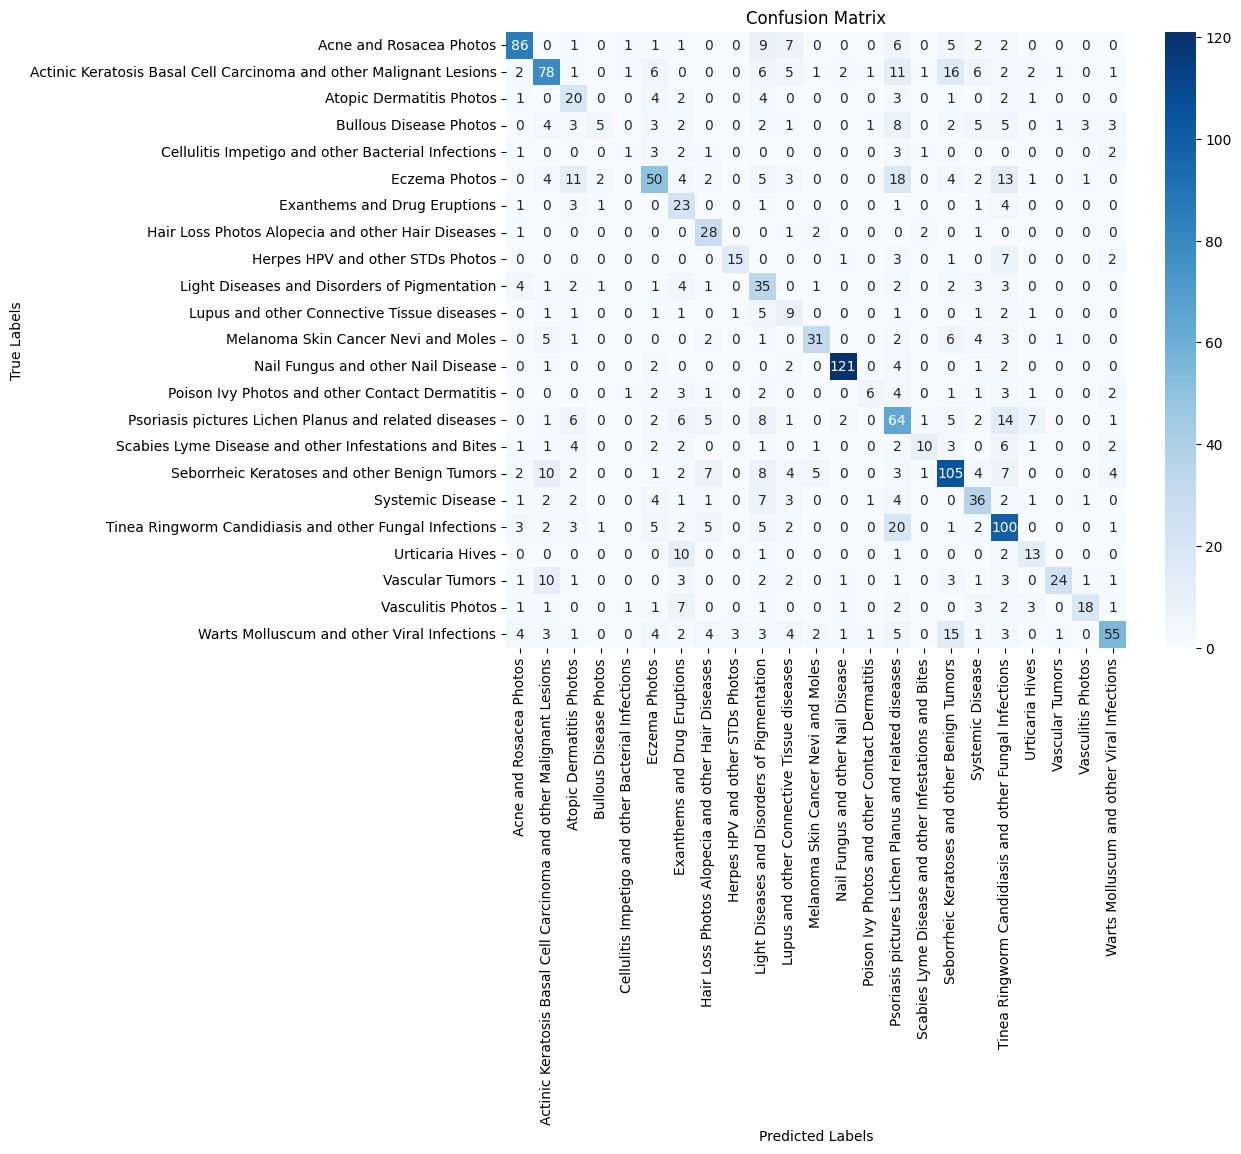

Classification Report:
                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos       0.79      0.71      0.75       121
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.63      0.55      0.58       143
                                          Atopic Dermatitis Photos       0.32      0.53      0.40        38
                                            Bullous Disease Photos       0.50      0.10      0.17        48
                Cellulitis Impetigo and other Bacterial Infections       0.20      0.07      0.11        14
                                                     Eczema Photos       0.54      0.42      0.47       120
                                      Exanthems and Drug Eruptions       0.30      0.66      0.41        35
                 Hair Loss Photos Alopecia and other Hair Diseases       0.49      0.80      0.61        35
    

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

# Optionally, visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=ds["train"].features["label"].names,
            yticklabels=ds["train"].features["label"].names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Generate the classification report
# Get unique labels present in your predictions and actuals
unique_labels = sorted(list(set(actual_labels + predicted_labels)))

# Filter target_names to include only the labels present in your predictions/actuals
filtered_target_names = [ds["train"].features["label"].names[label] for label in unique_labels]

# Now, generate the report using the filtered target names
report = classification_report(
    actual_labels,
    predicted_labels,
    target_names=filtered_target_names,  # Use the filtered names
    labels=unique_labels  # Optional: explicitly specify the labels for clarity
)

print("Classification Report:")
print(report)
